In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from kdg.utils import plot_2dsim, gaussian_sparse_parity, generate_gaussian_parity
from tqdm import tqdm

In [18]:
class TaskDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.clone()
        self.y = y.clone()

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()
        self.layer1 = nn.Linear(input_size, 10000)
        self.bn1 = nn.BatchNorm1d(10000)
        self.layer2 = nn.Linear(10000, 10000)
        self.bn2 = nn.BatchNorm1d(10000)
        self.layer3 = nn.Linear(10000, 10000)
        self.bn3 = nn.BatchNorm1d(10000)
        self.layer4 = nn.Linear(10000, 10000)
        self.bn4 = nn.BatchNorm1d(10000)
        self.output = nn.Linear(10000, latent_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(self.bn1(x))
        x = self.layer2(x)
        x = F.relu(self.bn2(x))
        x = self.layer3(x)
        x = F.relu(self.bn3(x))
        x = self.layer4(x)
        x = F.relu(self.bn4(x))
        x = self.output(x)

        return x
        

In [20]:
class Head(nn.Module):
    def __init__(self, latent_dim, output):
        super(Head, self).__init__()
        self.layer1 = nn.Linear(latent_dim, 100)
        self.layer2 = nn.Linear(100, 100)
        self.output = nn.Linear(100, output)
        

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)

        return x

In [94]:
class ContrastLoss(nn.Module):
    def __init__(self, latent_dim, margin=0.3):
        super(ContrastLoss, self).__init__()
        self.margin = margin

    def forward(self, inputs, targets, number_of_heads):
        #inputs = F.normalize(inputs, p=2.0, dim=0)
        dis_embedding = torch.cdist(
                            inputs,
                            inputs,
                            p=2.0
                        )
        kernel_partition = torch.sum(
                            targets.view(1,-1,number_of_heads)==targets.view(-1,1,number_of_heads),
                            dim=2)/number_of_heads
        
        #print(dis_embedding, kernel_partition)
        dis_partition = (1-kernel_partition)>1e-12
        #print(dis_partition)
        loss = torch.mul(
                        kernel_partition,
                        dis_embedding
                    ) + torch.clamp(torch.mul(
                        dis_partition,
                        self.margin-dis_embedding
                        ), 0.0) 
                
        return loss.mean()

In [95]:
class ClassificationLoss(nn.Module):
    def __init__(self):
        super(ClassificationLoss, self).__init__()

    def forward(self, inputs, targets):
        print(inputs.size(), targets.size())
        loss = -1 * (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        return loss.mean()

In [ ]:
total_task = 10
task_data = {}
heads = {}
classes_per_task = 2
sample_per_task = 2000
noise_dim = 8
latent_dim = 2
epoch_per_task_encoder = 20
epoch_per_task_head = 50
total_task_seen = 0
learning_rate_encoder = 3e-3
learning_rate_head = 3e-3
batch_size = 512
margin = .8
###########################
task_angles = np.linspace(0,np.pi/4, total_task)
encoder = Encoder(input_size=noise_dim+latent_dim, latent_dim=latent_dim)
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate_encoder, momentum=0.9)
criterion_encoder = ContrastLoss(latent_dim, margin=margin)

for ii, angle in enumerate(task_angles):
    print('Doing Task ', ii+1)
    
    X, y = generate_gaussian_parity(sample_per_task, angle_params=angle)
    X_noise = np.random.uniform(
                low=-1, high=1, size=(sample_per_task, noise_dim)
            )
    X = np.concatenate((X, X_noise), axis=1)
    
    X , y = torch.from_numpy(X.astype('float32')), torch.from_numpy(y.astype('float32'))
    y = y.view(-1,1)
    with torch.no_grad():
        for jj in range(total_task_seen):
            embedding = encoder(X)
            head_predicted_label = heads[jj](embedding).argmax(1).view(-1,1)
            y = torch.cat((y, head_predicted_label),
                        dim=1)
            
    #task_data[ii] = TaskDataset(X, y)
    train_loader = DataLoader(TaskDataset(X, y), batch_size=batch_size,
                                          shuffle=True)   
    ## train encoder ##
    for epoch in range(epoch_per_task_encoder):
        running_loss = 0.0
        for count, (X_, y_) in enumerate(train_loader):
            encoder_optimizer.zero_grad()
            embedding = encoder(X_)
            loss = criterion_encoder(embedding, y_, total_task_seen+1)
            #print(loss)
            loss.backward()
            encoder_optimizer.step()

            running_loss += loss.item()

        print("Epoch :", epoch+1, "loss :", running_loss/(count+1))
            

    ## train head ##
    heads[ii] = Head(latent_dim=latent_dim, output=classes_per_task)
    head_optimizer = torch.optim.SGD(heads[ii].parameters(), lr=learning_rate_head, momentum=0.9)
    criterion_head = nn.CrossEntropyLoss()
    
    for epoch in range(epoch_per_task_head):
        for X_, y_ in train_loader:
            head_optimizer.zero_grad()
            
            with torch.no_grad():
                embedding = encoder(X_)

            predicted_y = heads[ii](embedding)
            loss_head = criterion_head(predicted_y, y_[:,0].long())
            loss_head.backward()
            head_optimizer.step()
            
    print(f'head Epoch : {epoch+1}, loss: {loss_head:.4f}')
        
    total_task_seen += 1
    #break

Doing Task  1
Epoch : 1 loss : 0.4150458574295044
Epoch : 2 loss : 0.375464603304863
Epoch : 3 loss : 0.33336953073740005
Epoch : 4 loss : 0.30518830567598343
Epoch : 5 loss : 0.3006814047694206
Epoch : 6 loss : 0.2625163234770298
Epoch : 7 loss : 0.2567151375114918
Epoch : 8 loss : 0.24913141131401062
Epoch : 9 loss : 0.22530032321810722
Epoch : 10 loss : 0.2106696367263794
Epoch : 11 loss : 0.199499249458313
Epoch : 12 loss : 0.20233703777194023
Epoch : 13 loss : 0.17287376523017883
Epoch : 14 loss : 0.16263923421502113
Epoch : 15 loss : 0.1610548049211502
Epoch : 16 loss : 0.17257184907794
Epoch : 17 loss : 0.14980928227305412
Epoch : 18 loss : 0.1466306671500206
Epoch : 19 loss : 0.13986734673380852
Epoch : 20 loss : 0.1467375047504902
head Epoch : 50, loss: 0.0343
Doing Task  2
Epoch : 1 loss : 0.32268310338258743
Epoch : 2 loss : 0.30038562417030334
Epoch : 3 loss : 0.28074658662080765
Epoch : 4 loss : 0.26896239444613457
Epoch : 5 loss : 0.2515437379479408
Epoch : 6 loss : 0.251

In [408]:
task = 6
X, y = generate_gaussian_parity(1000, angle_params=task_angles[task])
X_noise = np.random.uniform(
            low=-1, high=1, size=(1000, noise_dim)
        )
X = np.concatenate((X, X_noise), axis=1)

X , y = torch.from_numpy(X.astype('float32')), torch.from_numpy(y.astype('float32'))

In [409]:
embedding = encoder(X)
head_predicted_label = heads[task](embedding).argmax(1).view(-1,1)

In [410]:
criterion_encoder = ContrastLoss(latent_dim)
#criterion_encoder(embedding, y, 3)

<AxesSubplot: >

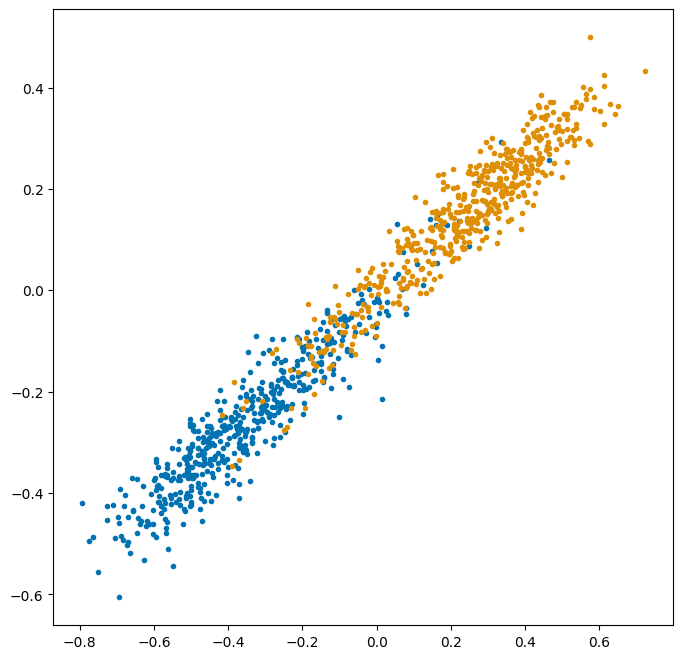

In [411]:
plot_2dsim(embedding.detach().numpy(), y.view(-1).numpy().astype('int'))

<AxesSubplot: >

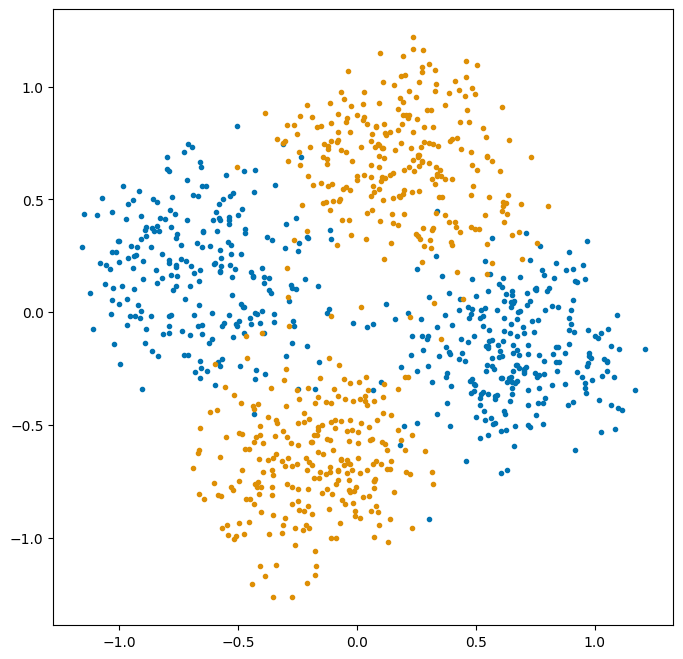

In [412]:
plot_2dsim(X.detach().numpy()[:,:2], y.view(-1).numpy().astype('int'))

In [413]:
torch.sum(y.view(-1,1)==head_predicted_label)/1000

tensor(0.8940)